<a href="https://colab.research.google.com/github/tomonari-masada/course2022-sml/blob/main/09_logistic_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022/06/11の課題
 * https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import StratifiedKFold

%config InlineBackend.figure_format = 'retina'

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/data/diabetes.csv')

In [3]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

## チューニングなしのロジスティック回帰をベースラインとしてテストデータで評価

In [5]:
baseline = LogisticRegression(max_iter=1000, random_state=123)
baseline.fit(X_train, y_train)
print(f'test score: {baseline.score(X_test, y_test):.4f}')
y_test_pred_proba = baseline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')

test score: 0.8103
ROC AUC: 0.8617


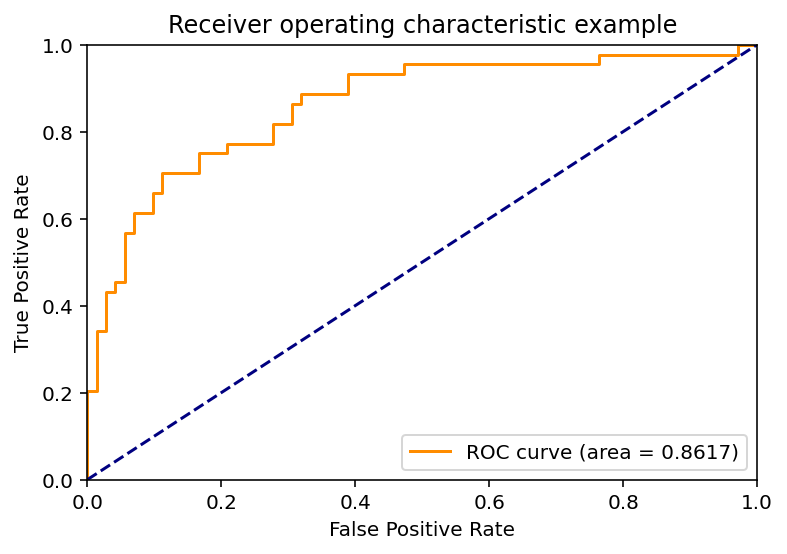

In [6]:
y_score = baseline.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right");

* これをベースラインとみなす。
* これより良い結果を得るべく、試行錯誤する。
* 試行錯誤した結果として辿り着いたモデルで、最後に一回、テストデータ上での評価を行う。

In [7]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

## 交差検証の準備

In [8]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [9]:
def cv(skf, X_train, y_train, verbose=False, 
       preprocess=None, preprocess_args=None,
       **kwargs):

  if verbose:
    print(end='\t')
    for kwarg in kwargs:
      print(f'{kwarg} = {kwargs[kwarg]}', end=', ')
    print()

  scores = list()
  for train_index, valid_index in skf.split(X_train, y_train):

    cv_X_train = X_train.iloc[train_index]
    cv_y_train = y_train.iloc[train_index]
    cv_X_valid = X_train.iloc[valid_index]
    cv_y_valid = y_train.iloc[valid_index]

    # データの前処理
    #   その都度、関数preprocessを定義してから、この関数cvを呼び出す。
    if preprocess:
      cv_X_train, cv_X_valid = preprocess(cv_X_train, cv_X_valid, preprocess_args)

    # ロジスティック回帰の学習
    if not 'max_iter' in kwargs:
      model = LogisticRegression(**kwargs, max_iter=1000)
    else:
      model = LogisticRegression(**kwargs)
    model.fit(cv_X_train, cv_y_train)

    # 検証データでの評価
    score = model.score(cv_X_valid, cv_y_valid)
    #print(f'score: {score:.4f}')
    scores.append(score)

  mean_score = np.array(scores).mean()
  #print(f'mean score: {mean_score:.4f}')
  return mean_score

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# k は関数外で指定しておく

def preprocess(X_train, X_valid, preprocess_args=None):

  X_train_copy = X_train.copy()
  X_valid_copy = X_valid.copy()

  imp = SimpleImputer(missing_values=0, strategy='median')
  for feature in ['BloodPressure', 'BMI', 'Glucose']:
    X_train_copy[feature] = imp.fit_transform(X_train_copy[[feature]])
    X_valid_copy[feature] = imp.transform(X_valid_copy[[feature]])

  X_train_copy['Age2'] = X_train_copy['Age'] ** 2
  X_valid_copy['Age2'] = X_valid_copy['Age'] ** 2

  if 'k' in preprocess_args:
    k = preprocess_args['k']
    if k > 0: # k=0はk-NNを使わないという意味になる
      columns = X_train_copy.columns.drop('SkinThickness').drop('Insulin')
      for feature in ['SkinThickness', 'Insulin']:
        reg = KNeighborsRegressor(n_neighbors=k)
        indices = (X_train_copy[feature] != 0)
        reg.fit(X_train_copy.loc[indices, columns], X_train_copy.loc[indices, feature])
        X_train_copy.loc[~indices, feature] = reg.predict(X_train_copy.loc[~indices, columns])
        indices = (X_valid_copy[feature] != 0)
        X_valid_copy.loc[~indices, feature] = reg.predict(X_valid_copy.loc[~indices, columns])

  return X_train_copy, X_valid_copy

In [11]:
best_score = 0.0
for penalty in ['l2', 'l1', 'none']:
  C_width = 4
  if penalty == 'none': C_width = 1
  for C in 10.0 ** np.arange(-1, -1 + C_width):
    for k in range(0, 11): # k=0はk-NNを使わないという意味になる
      if penalty == 'none':
        score = cv(
            skf, X_train, y_train, 
            preprocess=preprocess, preprocess_args={'k': k},
            penalty=penalty, max_iter=5000
            );
      elif penalty == 'l1':
        score = cv(
            skf, X_train, y_train, 
            preprocess=preprocess, preprocess_args={'k': k},
            C=C, penalty=penalty, solver='liblinear', max_iter=5000
            );
      else:
        score = cv(
            skf, X_train, y_train, 
            preprocess=preprocess, preprocess_args={'k': k},
            C=C, penalty=penalty, max_iter=5000
            );
      if score > best_score:
        best_score = score
        best_penalty = penalty
        best_C = C
        best_k = k
      print(f'mean accuracy: {score:.4f} ({k}-NN, penalty {penalty}, C={C:.2e})')
print(f'best mean accuracy: {best_score:.4f} ({best_k}-NN, penalty {best_penalty}, C={best_C:.2e})')

mean accuracy: 0.7652 (0-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7759 (1-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7728 (2-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7743 (3-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7743 (4-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7805 (5-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7743 (6-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7774 (7-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7759 (8-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7744 (9-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7759 (10-NN, penalty l2, C=1.00e-01)
mean accuracy: 0.7697 (0-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7666 (1-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7728 (2-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7743 (3-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7728 (4-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7728 (5-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7712 (6-NN, penalty l2, C=1.00e+00)
mean accuracy: 0.7697 (7-NN, penalty l2, C=1.

## テストデータで最終評価

In [12]:
X_train_preprocessed, X_test_preprocessed = preprocess(X_train, X_test, preprocess_args={'k': best_k})
if best_penalty == 'none':
  logreg = LogisticRegression(penalty=best_penalty, max_iter=5000, random_state=123)
elif best_penalty == 'l1':
  logreg = LogisticRegression(C=best_C, penalty=best_penalty, solver='liblinear', max_iter=5000, random_state=123)
else:
  logreg = LogisticRegression(C=best_C, penalty=best_penalty, max_iter=5000, random_state=123)
logreg.fit(X_train_preprocessed, y_train)

LogisticRegression(C=0.1, max_iter=5000, random_state=123)

In [13]:
print('test score: {:.4f}'.format(logreg.score(X_test_preprocessed, y_test)))

test score: 0.7672


In [14]:
y_test_pred_proba = logreg.predict_proba(X_test_preprocessed)
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba[:,1])))

ROC AUC: 0.8734


* AUCは改善されている。

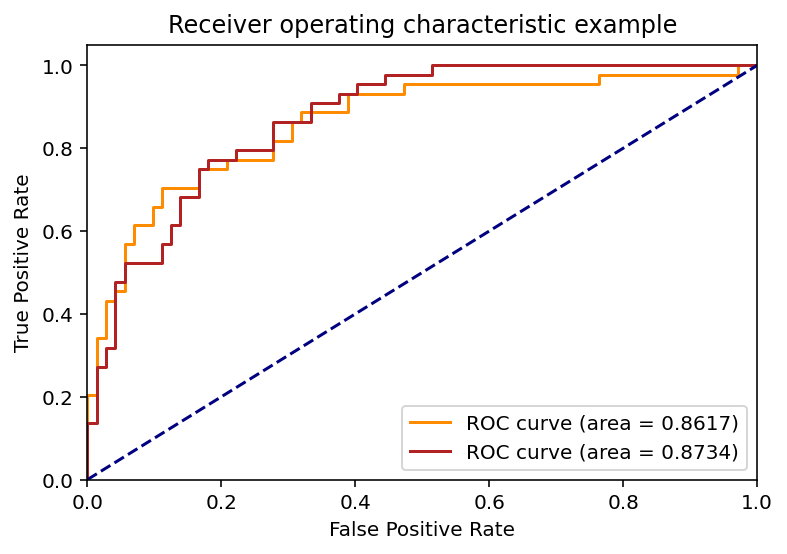

In [15]:
y_score = baseline.decision_function(X_test_original) # ベースラインには元のテストデータを使う
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

y_score_ours = logreg.decision_function(X_test_preprocessed)
fpr_ours, tpr_ours, _ = roc_curve(y_test, y_score_ours)
roc_auc_ours = auc(fpr_ours, tpr_ours)

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot(fpr_ours, tpr_ours, color='firebrick', label=f'ROC curve (area = {roc_auc_ours:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right");